# 0. Overview

We will be analyzing an extract of 1994 U.S. Census data. See more on the data set [here](https://archive.ics.uci.edu/ml/datasets/census+income). First, we are going to need some help from some well-known, third-party libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Third-party libraries are libraries (collections of code) that do not come with the core Python distribution. You can get these libraries through downloading the Anaconda distribution, which includes them all, or through installing them manually with `pip` (or `pip3`, depending on your system), which is the Python package manager.

When importing a Python library, you can give it an alias, which is usually done to make something easier to type. It's good to follow standard protocol for a given library when doing this so that other people will recognize it throughout your code. 

`numpy` (typically abbreviated as `np`) provides the following:
- a homogenous (read: for a single data type) array with very useful manipulation methods
- a number of useful advanced math functions
- other data type helpers
- in many ways `numpy` is a collection of Python wrappers for very well-optimized C and FORTRAN math code

`pandas` (typically abbreviated as `pd`) is:
- a library that provides, amongst other things, a very nice data structure known as the `DataFrame`
- the `DataFrame` is a relational / tabular data structure
- i.e. it allows you to do SQL-ish anlysis in Python
- it also visualizes nicely in Jupyter notebooks
- a good bit of Pandas is actually just user-friendly interfaces on top of `numpy`

`matplotlib` (from which the `pyplot` submodule is typically imported and aliased as `plt`)
- the old faithful data visualization library for Python
- it definitely provides a steep learning curve
- but it's a powerful tool once learned

`sklearn`
- the de-facto Python machine learning library
- provides fundamental predictive modeling frameworks like _linear regression_
- as well as more machine- learning-ish frameworks like that of the _random forest_
- in addition, it provides a lot of model evaluation functionality
- it doesn't really get into _deep learning_

In [2]:
%matplotlib inline

The above is a _magic_ Jupyter command that ensures all `matplotlib` plots will by default show in the notebook.

# 1. Get Data

### Retrieve and quick look

`pandas` provides us with a function that makes it very easy to read in tabular data: `read_csv()`. In this case we pass the name of the file we want to read along with the value `None` for `header`, which tells the function that the file does not have a header / column name row.

In [3]:
data = pd.read_csv("census_data.csv", header=None)

When we read the data using this function, we are returned a `DataFrame` - this is a `pandas` data structure that is very useful for data analysis, in part because they provide a whole lot of very convenient methods (they also visualize well in Jupyter notebooks). We can look at a `tuple` of (`number of rows`, `number of columns`):

In [4]:
data.shape

(32561, 15)

We can call `.iloc` on the `DataFrame` to select rows based on their _integer location_, kind of like we'd do with a `tuple`or `list`. In fact, the same slicing rules apply:

In [5]:
data.iloc[:5, :8]

,0,1,2,3,4,5,6,7
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife


We see that, as expected, the data came in with no columns. I know the column names, so we can create a `list` of column names (whose length must be equal to the width of the `DataFrame`) and set the `DataFrame`'s `columns` attribute equal to it:

In [6]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 
        'education_num', 'marital_status', 'occupation',
        'relationship', 'race', 'sex', 'capital_gain',
        'capital_loss', 'hours_per_week', 'native_country', 
        'over_fifty_k']

In [7]:
data.columns = cols

In [8]:
data.iloc[:5, :8]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife


I generally like to start any analysis by looking at the top and bottom of the data that's been read in, to ensure columns are named appropriately, no junk data was picked up at the end, etc.

In [9]:
data.iloc[-5:, -7:]

,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k
32556,White,Female,0,0,38,United-States,<=50K
32557,White,Male,0,0,40,United-States,>50K
32558,White,Female,0,0,40,United-States,<=50K
32559,White,Male,0,0,20,United-States,<=50K
32560,White,Female,15024,0,40,United-States,>50K


### Cleanliness check

It's important to always check to see if you have any duplicates or missing values in your data before you really get going. `pandas` makes both tasks very easy:

In [10]:
data.duplicated().sum()

24

In this case we have some duplicates in our data! Let's take a look at where they are in the index:

In [11]:
data[data.duplicated()].index

Int64Index([ 4881,  5104,  9171, 11631, 13084, 15059, 17040, 18555, 18698,
            21318, 21490, 21875, 22300, 22367, 22494, 25872, 26313, 28230,
            28522, 28846, 29157, 30845, 31993, 32404],
           dtype='int64')

One of the ways in which we can filter a `DataFrame` is to pass a condition into it using square brackets, e.g. `data[data.duplicated()]`. `duplicated()` is a method that returns `True` for every row in `data` that is a duplicate. The square bracket syntax works such that it will then return the rows in the `DataFrame` that have a value of `True`. So, `duplicated` returns a whole collection of `True` or `False` values for each position in the index, and the square bracket syntax then returns the rest of the row for each `True` index value. 

In this case, we only want the index of these rows, not the whole row, so we call the `index` attribute on the results of the square bracket query. Let's look at another example:

In [12]:
len(data[data.capital_gain > 0])

2712

Above we've filtered the `DataFrame` to only the rows in which `capital_gain` is greater than 0. We then pass the results of that into the built-in `len` function, which will tell you how many items are in the iterable that's been passed. Now, let's go ahead and drop our duplicate values:

In [13]:
data = data.drop_duplicates()

In [14]:
data.duplicated().sum()

0

We can also check for `null` or missing values:

In [15]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
over_fifty_k      0
dtype: int64

# 2. Exploratory Data Analysis

Exploratory data analysis (EDA) is key to understanding your data - this is where you poke around and see how things work.

In [16]:
data.dtypes.value_counts()

object    9
int64     6
dtype: int64

`data.dtypes` tells us the data type for every column in `data`. The `value_counts()` method then returns the frequency of each type.

### `education`

Let's dive deeper into a single column of the `DataFrame`. `DataFrame` columns are instances of what `pandas` calls the `Series` class - they're kinda like `DataFrames`, and the two have many common attributes and methods, but `Series` objects contain for all intents and purposes only an index and a single column of data.

In [17]:
data.education.nunique()

16

`nunique()` is a `Series` method that tells us how many unique values there are. 

Note that `value_counts()` is available to call on the ouput of `data.dtypes` because `data.dtypes` actually returns the dtype information as a `Series`. Many `pandas` methods in fact return `Series` objects, e.g. `value_counts()` as well.

We can also run `value_counts()` on the `data.education` series to look at the frequencies of these values. 

In [18]:
data.education.value_counts()

 HS-grad         10494
 Some-college     7282
 Bachelors        5353
 Masters          1722
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           645
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           332
 1st-4th           166
 Preschool          50
Name: education, dtype: int64

We can pass `normalize=True` to `value_counts()` to see, instead of the value count, the value proportion of the entire dataset:

In [19]:
data.education.value_counts(normalize=True)

 HS-grad         0.322525
 Some-college    0.223807
 Bachelors       0.164520
 Masters         0.052924
 Assoc-voc       0.042475
 11th            0.036113
 Assoc-acdm      0.032793
 10th            0.028675
 7th-8th         0.019824
 Prof-school     0.017703
 9th             0.015797
 12th            0.013308
 Doctorate       0.012693
 5th-6th         0.010204
 1st-4th         0.005102
 Preschool       0.001537
Name: education, dtype: float64

We can turn `Series` objects into `DataFrame` objects pretty easily:

In [20]:
ed_val_cnts_norm = data.education.value_counts(normalize=True)

In [21]:
ed_val_cnts_norm = ed_val_cnts_norm.rename("normalized")

In [22]:
ed_val_cnts_norm = ed_val_cnts_norm.to_frame()

In [23]:
ed_val_cnts_norm

,normalized
HS-grad,0.322525
Some-college,0.223807
Bachelors,0.164520
Masters,0.052924
Assoc-voc,0.042475
11th,0.036113
Assoc-acdm,0.032793
10th,0.028675
7th-8th,0.019824
Prof-school,0.017703


We can now `join` in the results of the non-normalized call if we'd like to retain both. `join` is a relational data concept that anyone who knows SQL will be familiar. The analog in Excel (I don't do much Excel) is probably `vlookup`.

In [24]:
ed_val_cnts_norm = ed_val_cnts_norm.join(data.education.value_counts().rename("cnt"))

In [25]:
ed_val_cnts_norm.head()

,normalized,cnt
HS-grad,0.322525,10494
Some-college,0.223807,7282
Bachelors,0.164520,5353
Masters,0.052924,1722
Assoc-voc,0.042475,1382


In [26]:
ed_val_cnts_norm.sort_values("normalized").head()

,normalized,cnt
Preschool,0.001537,50
1st-4th,0.005102,166
5th-6th,0.010204,332
Doctorate,0.012693,413
12th,0.013308,433


`head` is a great `DataFrame` and `Series` method that by default returns the first 5 rows. You can pass other integer values to it, too.`sort_values` allows us to sort by a specified column. `sort_index` will sort based on the index. Both of these sort methods are available for `Series` (no column name needed) and `DataFrame` objects.

Let's visualize some of our data:

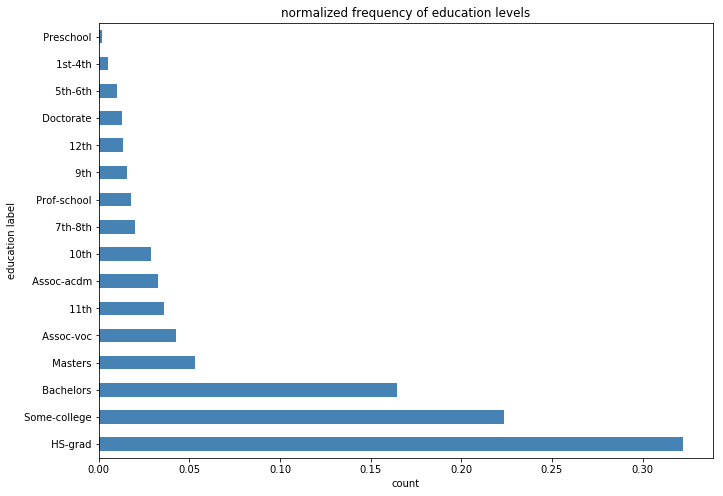

In [27]:
ax = data.education.value_counts(normalize=True).plot.barh(figsize=(11, 8), color="steelblue")
xlab = ax.set_xlabel("count")
ylab = ax.set_ylabel("education label")
t = ax.set_title("normalized frequency of education levels")

`DataFrame` and `Series` objects come with some nice plotting functionality built-in, a lot of which wraps the `matplotlib` library. One of the ways to get at the different types of plots is to first reference `plot` (as we did) but not call it (i.e. no `()`) and instad call a particular type of plot method available through `plot` (in this case, `barh`).

We passed some arguments to `barh()` to change the size of the plot and the color of the bars. We've also set X and Y labels, as well as a title (always give your plots titles!). 

### Problem

Pick another column to run `value_counts` on. Plot the results as a **vertical** bar plot. Do you see anything interesting? Feel free to experiment with different plot sizes and colors!

### `over_fifty_k`

In [28]:
data.over_fifty_k.value_counts(normalize=True)

 <=50K    0.759074
 >50K     0.240926
Name: over_fifty_k, dtype: float64

In [29]:
data.over_fifty_k.unique()

array([' <=50K', ' >50K'], dtype=object)

In this case, I don't love these `str` representations of what is really `bool` data (you can see that they have issues, in the form of leading spaces). Let's write a function to convert these values to `bool` type, and then `apply` that function over the rows of the `DataFrame`. The `apply` method allows you to write your own functionality when the `DataFrame` doesn't have what you want built-in:

In [30]:
def is_over_fifty_k(income):
    return income.strip() == ">50K"

In [31]:
data["over_fifty_k_bool"] = data.over_fifty_k.apply(is_over_fifty_k)

The above shows how you create a new column in `pandas`: `df["new_column_name"] = ...`

In [32]:
data.over_fifty_k_bool.head()

0    False
1    False
2    False
3    False
4    False
Name: over_fifty_k_bool, dtype: bool

In [33]:
data.over_fifty_k_bool.value_counts(normalize=True)

False    0.759074
True     0.240926
Name: over_fifty_k_bool, dtype: float64

### `capital_gain`

In [34]:
data.capital_gain.describe()

count    32537.000000
mean      1078.443741
std       7387.957424
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital_gain, dtype: float64

A great way to get acquainted with a `Series` (or `DataFrame`) is to call the `describe()` method, which will return a `Series` of the following descriptive statistics (for continuous data - the results are a little different for categorical / label data):
- number of non-null items
- arithmetic average and stardard deviation
- the following quantiles: [0, .25, .5, .75, 1]

Note that you can also produce all these statistics individually:

In [35]:
data.capital_gain.median()

0.0

Let's graph `data.capital_gain` as a histogram, which buckets the data into evenly-spaced bins and returns the number of items in each bin. This will give us a good feel for the data's distribution:

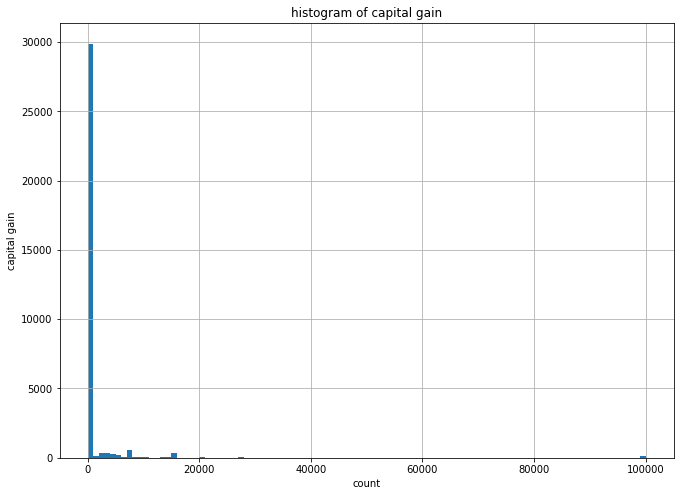

In [36]:
ax = data.capital_gain.hist(figsize=(11, 8), bins=100)
xlab = ax.set_xlabel("count")
ylab = ax.set_ylabel("capital gain")
t = ax.set_title("histogram of capital gain")

We can see that so much of `data.capital_gain` has a value of 0 that is makes the rest of the data hard to look at. Let's filter to only values greater than 0 and try again:

In [37]:
capital_gains_filtered = data.loc[data.capital_gain > 0, "capital_gain"]

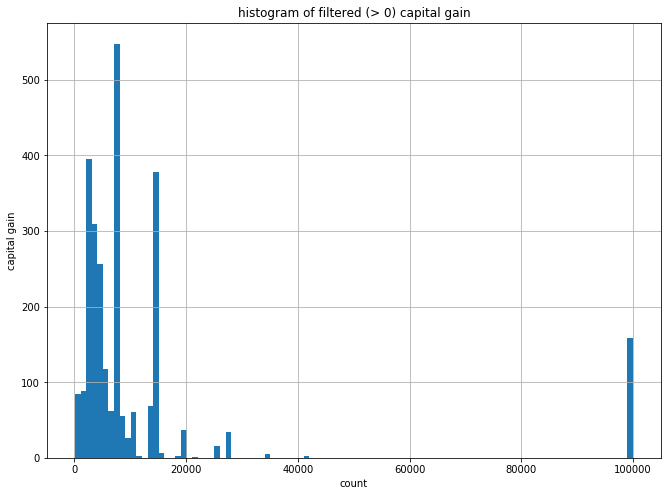

In [38]:
ax = capital_gains_filtered.hist(figsize=(11, 8), bins=100)
xlab = ax.set_xlabel("count")
ylab = ax.set_ylabel("capital gain")
t = ax.set_title("histogram of filtered (> 0) capital gain")

This is an interesting distribution - we see a sort of positively skewed (long tail to the right) mess with a weird spike at $100,000, where this data was likely capped and bucketed. We can reduce the skewness through taking the log transform of this data, with the help of `numpy`:

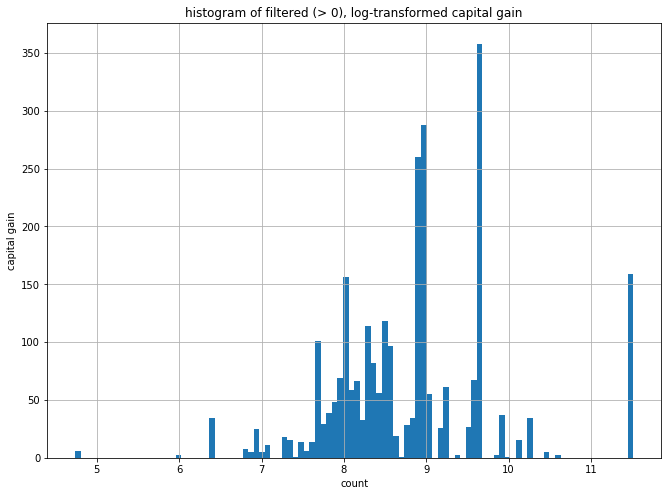

In [39]:
ax = capital_gains_filtered.apply(np.log).hist(figsize=(11, 8), bins=100)
xlab = ax.set_xlabel("count")
ylab = ax.set_ylabel("capital gain")
t = ax.set_title("histogram of filtered (> 0), log-transformed capital gain")

We can get a closer look at the data's distribution using the `quantile()` method:

In [40]:
data.capital_gain.quantile([.8, .9, .95, .99])

0.80        0.0
0.90        0.0
0.95     5013.0
0.99    15024.0
Name: capital_gain, dtype: float64

### Problem

Perform a similar analysis to what we did for `capital_gain` on `capital_loss`.

### Back to `capital_gain`

Let's say that we came to find out that all of the 0's in `capital_gain` were in fact just representations of `null` data. 

Note that people really do this, and that it's terrible - this is numerical data, which means that 0 has a meaning. The only time this really makes sense is if 0 is actually an extreme / impossible value for the data. Even then, that would be considered a pre-modeling treatment and not something you'd want to distribute to other folks.

But let's say hypothetically this happened, what would you do? You might start by re-representing the `null` data in its correct form.

In [41]:
cap_gain_missing = data.capital_gain

In [42]:
cap_gain_missing = cap_gain_missing.apply(lambda x: np.nan if x == 0 else x)

Here we've run `apply` with a function that returns `np.nan` (a `pandas`-friendly `null` encoding from `numpy`), but instead of using the usual `def` syntax to define the function, we've used `lambda`.

Our `lambda` function is what's referred to as an anonymous function, as it's never formally defined and given a name. This can be a great way to write on-the-go or throw-away functions (as we've done here).

In [43]:
cap_gain_missing.isnull().sum()

29825

We can now quickly fill our missing values using the `fillna()` method, if we've determined that replacing with 0 is the right thing to do:

In [44]:
cap_gain_missing = cap_gain_missing.fillna(0)

In [45]:
cap_gain_missing.isnull().sum()

0

### Problem

Create a new `Series` based on the `marital_status` column, which will be `True` only if someone is married, and make that happen by passing an anonymous function to `apply()`. 

### Looking at multiple columns: `education` and `over_fifty_k_bool`:

Let's say you'd want to look at how one data set lies when it's grouped around another - how would you do that? You would call the `groupby()` method, which operates similarly to the `group by` syntax in SQL, and some of the functionality of which is encapulated in `pivot` in Excel.

`groupby()` works as follows:
1. select the data you'd like to query
2. call `groupby()` and pass to it the column(s) you'd like to group around
3. call some sort of aggregation function

In this case we want to:
1. query education against income, so we call `data[["education", "over_fifty_k_bool"]]` (multiple columns requires `[[]]`)
2. pass both columns to `groupby`. This might seem a little strange but is common for categorical / labeled data
3. call `size()`, which will give us the number of items in each group

In [46]:
data[["education", "over_fifty_k_bool"]
    ].groupby(["over_fifty_k_bool", "education"]
    ).size(
    ).rename("cnt"
    ).to_frame()

cnt
over_fifty_k_bool education          
False              10th           871
                   11th          1115
                   12th           400
                   1st-4th        160
                   5th-6th        316
                   7th-8th        605
                   9th            487
                   Assoc-acdm     802
                   Assoc-voc     1021
                   Bachelors     3132
                   Doctorate      107
                   HS-grad       8820
                   Masters        763
                   Preschool       50
                   Prof-school    153
                   Some-college  5896
True               10th            62
                   11th            60
                   12th            33
                   1st-4th          6
                   5th-6th         16
                   7th-8th         40
                   9th             27
                   Assoc-acdm     265
                   Assoc-voc      361
                   Bachelors     2221
                   Doctorate      306
                   HS-grad       1674
                   Masters        959
                   Prof-school    423
                   Some-college  1386

We can now follow a similar tract to an above analysis and get size as a ratio (aka normalized size):

In [47]:
income_ed_grouped = data[["education", "over_fifty_k_bool"]
                         ].groupby(["over_fifty_k_bool", "education"]
                         ).size(
                         ).rename("cnt"
                         ).to_frame()

In [48]:
income_ed_grouped["ratio"] = income_ed_grouped / len(data)

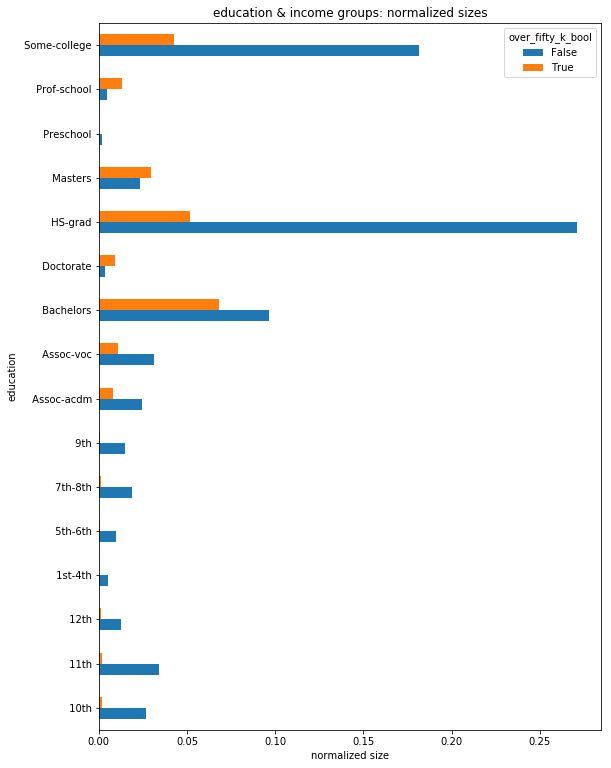

In [49]:
ax = income_ed_grouped.ratio.unstack(0).plot.barh(figsize=(9, 13))
xlab = ax.set_xlabel("normalized size")
t = ax.set_title("education & income groups: normalized sizes")

### Problem

Pick two columns you'd like to study together and query them using `groupby()`, choosing an aggregation function that makes sense (common statistical functions, like `mean()` and `std()` are available).

# 3. Modeling

We are going to do a very quick modeling exercise here to get you ever-so-slightly acquainted with `sklearn`. To really build a predictive model, you need to go much deeper than this, but this should be enough to give you a taste of what this stuff is like.

We are going to try to build a model to predict whether or not someone has made more than $50,000, and we are going to use a decision tree classifier. Classifiers are models that predict classes (labels) as opposed to continuous values: e.g. `is_rent_increasing` (yes / no) vs. `rent_t_plus_1` (in dollars). Decision trees are a framework for modeling in which you build a set of rules, twenty- questions style, to help you make predictions.

Let's get the columns we'd like to use for making predictions, i.e. X:

In [50]:
X_cols = ['age', 'workclass', 'fnlwgt', 'education', 
          'education_num', 'marital_status', 'occupation',
          'relationship', 'race', 'sex', 'capital_gain',
          'capital_loss', 'hours_per_week', 'native_country']

In [51]:
data[X_cols].dtypes.sort_values()

age                int64
fnlwgt             int64
education_num      int64
capital_gain       int64
capital_loss       int64
hours_per_week     int64
workclass         object
education         object
marital_status    object
occupation        object
relationship      object
race              object
sex               object
native_country    object
dtype: object

The categorical (`object`) data here will have to be re-engineered into `bool` values. E.g. an `education` column that held values: ["bachelors", "masters", "phd"] would be transformed into a matrix with 3 columns, all yes or no: `is_bachelors`, `is_masters`, `is_phd`. This is called dummy- or one-hot-encoding.

There is more nuance to this that we're not going to get into. For now, we're just going to crudely dump all our `object` columns into the `pandas` function `get_dummies()`.

We can use the `DataFrame` method `select_dtypes` to only select the `object` columns.

In [52]:
obj_srs = data[X_cols].select_dtypes(include=object)

In [53]:
one_hot = pd.get_dummies(obj_srs)

We now create X by joining our one-hot data to our `int` data:

In [54]:
X = data[X_cols].select_dtypes(include=int).join(one_hot, how="inner")

For y, we'll just use `over_fifty_k_bool`:

In [55]:
y = data.over_fifty_k_bool

Now we need to split our data into training and testing sets, as you never want to test your model on the data that it was trained on, as you will get very over-generous performance estimates.

You also want to sample your data randomly, and you want to do this in such a way that the natural stratification of your target (what you're trying to predict) is observed. The `train_test_split` function from `sklearn` allows us to do this:

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

Now, we create a new `DecisionTreeClassifier` object:

In [57]:
tree = DecisionTreeClassifier()

We fit it to the training data:

In [58]:
tree = tree.fit(X_train, y_train)

And we predict our test data:

In [59]:
y_pred = tree.predict(X_test)

We get back a `numpy` array of predictions:

In [60]:
y_pred[:5]

array([False, False, False,  True, False])

We can compare these to our actual values to get a sense of performance:

In [61]:
accuracy_score(y_test, y_pred)

0.8133066994468346

So our model was 82% correct - not bad for so little work!

Let's say we want to save our predictions:

In [62]:
y_test.head()

24234    False
19374    False
6297     False
30448    False
27557    False
Name: over_fifty_k_bool, dtype: bool

In [63]:
y_test = y_test.rename("y_test").to_frame()

In [64]:
y_test["y_pred"] = y_pred

In [65]:
y_test.head()

,y_test,y_pred
24234,False,False
19374,False,False
6297,False,False
30448,False,True
27557,False,False


In [66]:
y_test.to_csv("y_test.csv")